# Creation of a Model for Power

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
!ls archive

Location1.csv Location2.csv Location3.csv Location4.csv readme.txt


## Importing Data

In [3]:
# Listing file directories
file_dirs = [
    "archive/Location1.csv", 
    "archive/Location2.csv", 
    "archive/Location3.csv", 
    "archive/Location4.csv"
]

# Creating a list of dataframes
dfs = [pd.read_csv(path) for path in file_dirs]

# Process each dataframe
for i in range(len(dfs)):
    df = dfs[i]
    
    # Convert time and extract features
    df["Time"] = pd.to_datetime(df["Time"])
    df["month"] = df["Time"].dt.month
    df["hour"] = df["Time"].dt.hour
    
    df.index = df["Time"]

## Exploratory Data Analysis

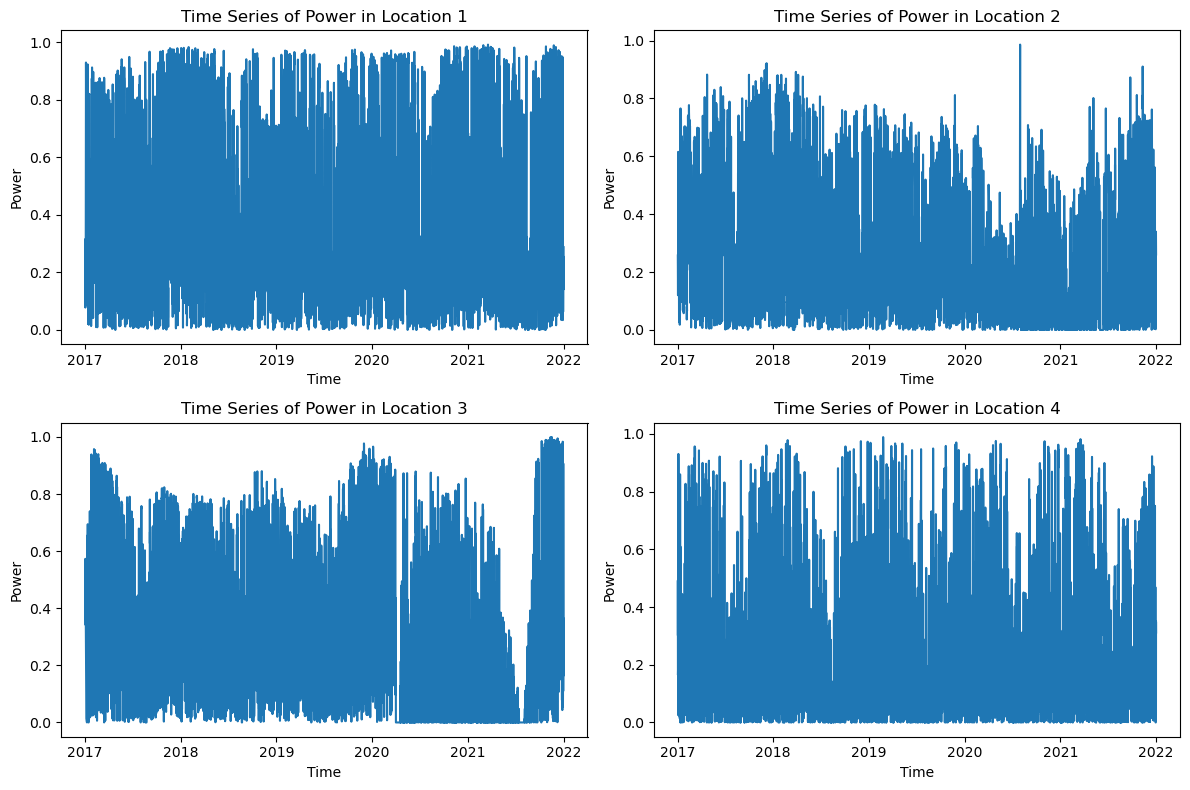

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].plot(df["Time"], df["Power"])
    axes[i].set_title(f"Time Series of Power in Location {i + 1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Power")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


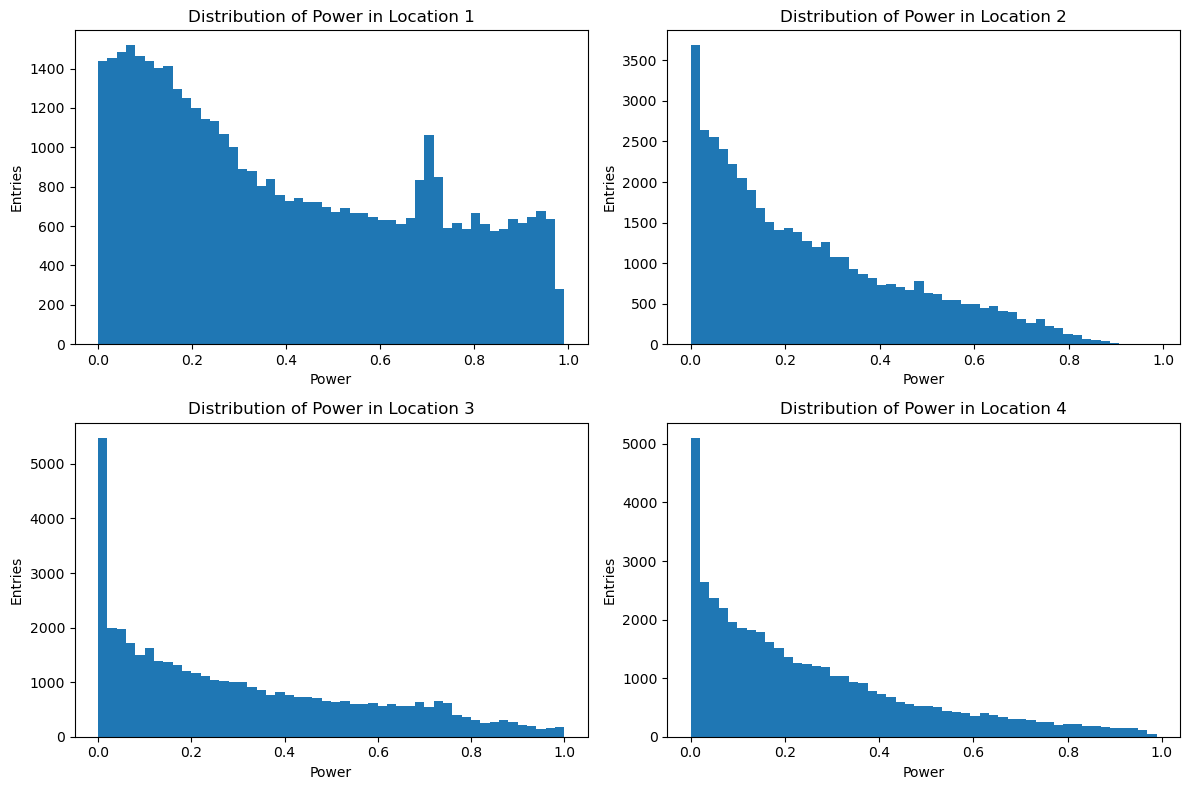

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].hist(df["Power"], bins=50)
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Power")
    axes[i].set_ylabel("Entries")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The distribution of power looks skewed. Specifically, it looks positively skewed. This shows that the generation of wind power is rarely maximized.

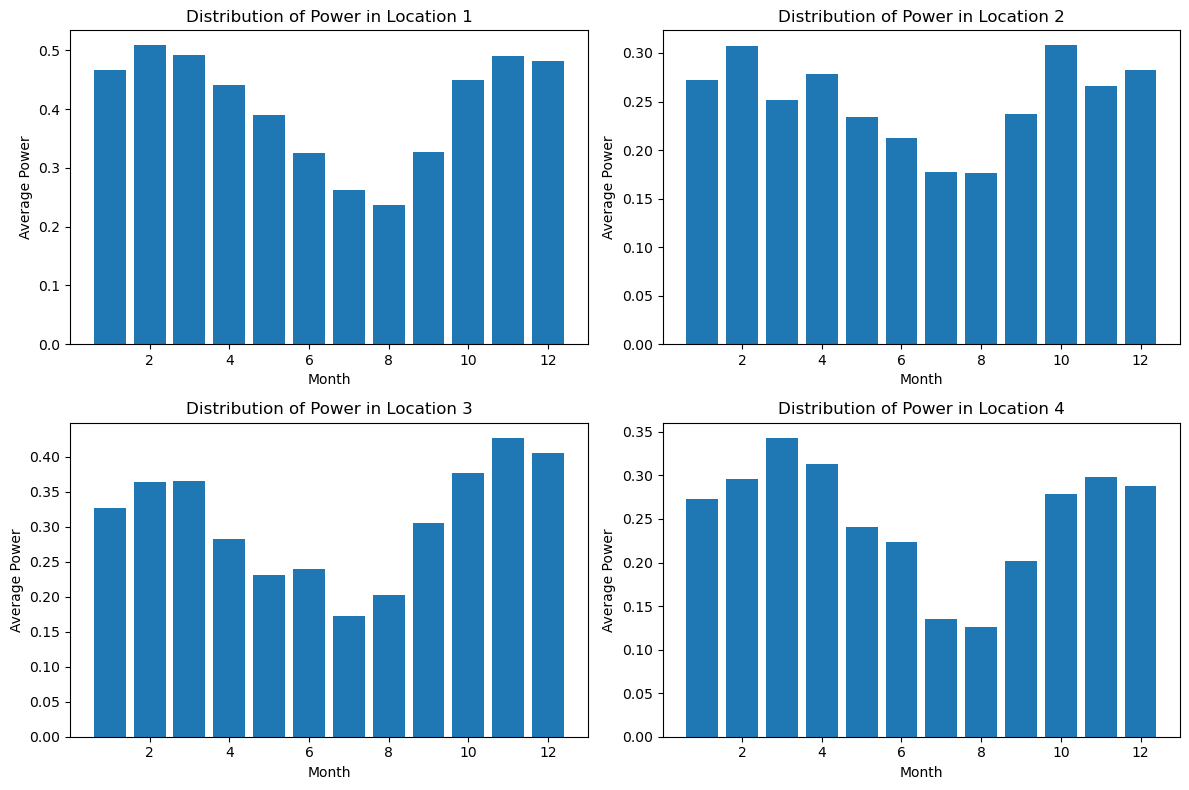

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].bar(
        df.groupby("month")["Power"].mean().index, 
        df.groupby("month")["Power"].mean()
    )
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Average Power")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Peak generation of power seems to come from February, March, October, and November.

In [7]:
for df in dfs:
    mean_month_power_guide = df.groupby("month")["Power"].mean()
    mean_hour_power_guide = df.groupby("hour")["Power"].mean()
    
    df["mean_power_for_month_glob"] = (
        df["month"].apply(
            lambda x: mean_month_power_guide[x]
        )
    )
    df["mean_power_for_hour_glob"] = (
        df["hour"].apply(
            lambda x: mean_hour_power_guide[x]
        )
    )

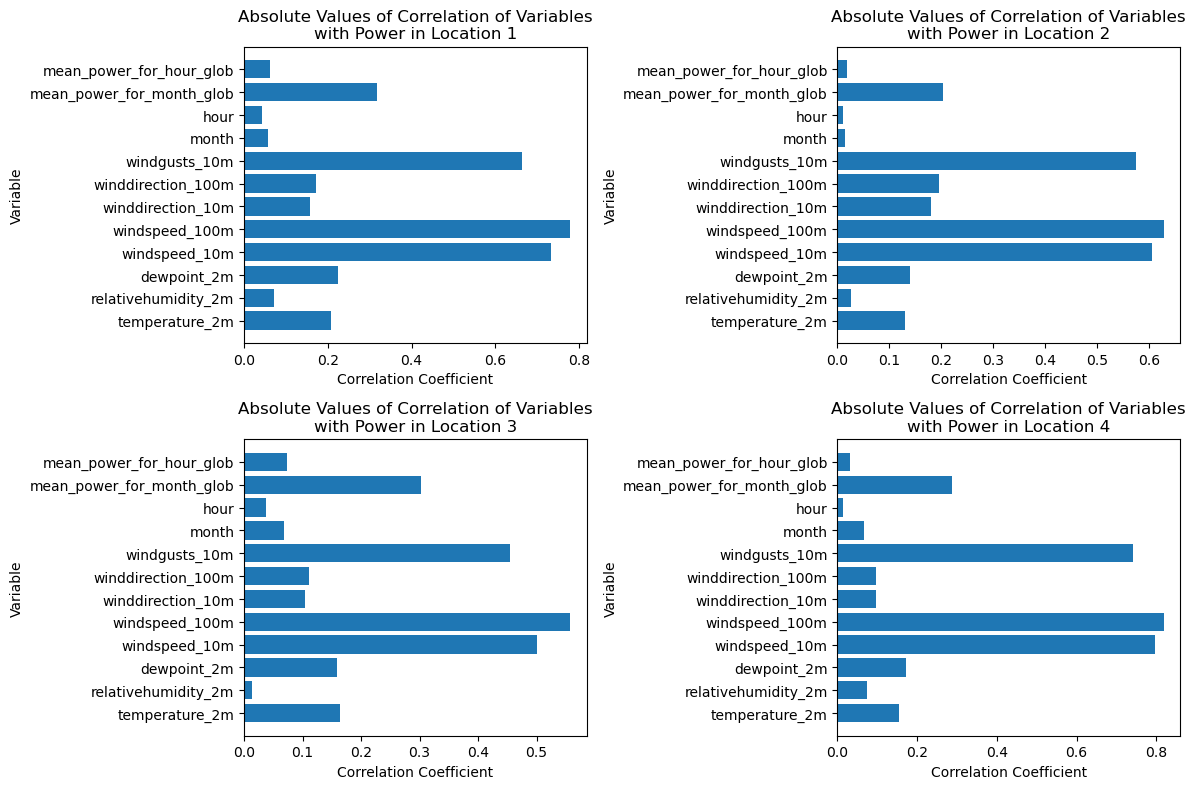

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, df in enumerate(dfs):
    corr_series = df.corr(numeric_only=True)["Power"].drop("Power")
    
    axes[i].barh(
        corr_series.index,
        np.abs(corr_series.values)
    )
    axes[i].set_title(
        "Absolute Values of Correlation of Variables\n"
        f"with Power in Location {i + 1}"
    )
    axes[i].set_xlabel("Correlation Coefficient")
    axes[i].set_ylabel("Variable")

plt.tight_layout()
plt.show()


`windgusts_10`, `windspeed_100m`, and `windspeed_10m` most likely have the most predictive power because they have the largest absolute values with power. However, this still has to be verified with SHAP values after the model has been created.

### Creating Columns for Previous Hours

In [9]:
# Process each dataframe
for i in range(len(dfs)):
    df = dfs[i]

    # Shift columns 1 to 48 steps ahead
    shifted_cols = []
    for col in df.columns:
        for j in range(1, 49):
            shifted = df[col].shift(j).rename(f"{col}-{j}")
            shifted_cols.append(shifted)
    
    # Concatenate all shifted columns at once
    df_shifted = pd.concat(shifted_cols, axis=1)

    # Combine with original df
    dfs[i] = pd.concat([df, df_shifted], axis=1)


In [10]:
dfs[0].head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,mean_power_for_hour_glob-39,mean_power_for_hour_glob-40,mean_power_for_hour_glob-41,mean_power_for_hour_glob-42,mean_power_for_hour_glob-43,mean_power_for_hour_glob-44,mean_power_for_hour_glob-45,mean_power_for_hour_glob-46,mean_power_for_hour_glob-47,mean_power_for_hour_glob-48
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-02 00:00:00,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 01:00:00,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 02:00:00,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 03:00:00,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 04:00:00,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# for i, df in enumerate(dfs):
#     print(f"===== LOCATION {i} =====")
#     prev_cols = [
#         col for col in df.columns
#         if "-" in col
#     ]
#     corrs = df[prev_cols + ["Power"]].corr()["Power"]

#     for key, value in corrs.items():
#         if key != "Power" and np.abs(value) > 0.25:
#             print(f"{key}: {value}")

#     print()

## Modeling

In [12]:
train_n = int(dfs[0].shape[0] * 0.7)
test_n = len(dfs[0]) - train_n

In [13]:
dfs_train = [
    df.head(train_n)
    for df in dfs
]
dfs_test = [
    df.tail(test_n)
    for df in dfs
]

### Limit Train and Test to Previous Data Only

In [14]:
dfs_train = [
    df[
        [
            col for col in df.columns
            if "-" in col
            and "glob" not in col
            and "Time" not in col
            and "hour" not in col
            and "month" not in col
        ] + 
        [ "hour", "month", "Power" ]
    ]
    for df in dfs_train
]
dfs_test = [
    df[
        [
            col for col in df.columns
            if "-" in col
            and "glob" not in col
            and "Time" not in col
            and "hour" not in col
            and "month" not in col
        ] + 
        [ "hour", "month", "Power" ]
    ]
    for df in dfs_test
]

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

In [16]:
df_train = dfs_train[0]

In [17]:
rmses = []

for i in tqdm(range(4)):
    # Split train/test
    X_train = dfs_train[i].iloc[:, :-1]
    y_train = dfs_train[i].iloc[:, -1]
    
    X_test = dfs_test[i].iloc[:, :-1]
    y_test = dfs_test[i]["Power"]
    
    # Impute missing values using training stats
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Train + predict
    regr = KNeighborsRegressor()
    regr.fit(X_train_imputed, y_train)
    y_pred = regr.predict(X_test_imputed)
    
    # Evaluate
    rmse = mean_squared_error(y_test, y_pred)
    rmses.append(rmse)

rmses

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it]


[0.0986341070219618,
 0.06699090140123279,
 0.12062776693810211,
 0.06372126660710753]

In [18]:
rmses = []

for i in tqdm(range(4)):
    # Split train/test
    X_train = dfs_train[i].iloc[:, :-1]
    y_train = dfs_train[i].iloc[:, -1]
    
    X_test = dfs_test[i].iloc[:, :-1]
    y_test = dfs_test[i]["Power"]
    
    # Impute missing values using training stats
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Train + predict
    clf = tree.DecisionTreeRegressor(random_state=0)
    clf = clf.fit(X_train_imputed, y_train)
    y_pred = clf.predict(X_test_imputed)
    
    # Evaluate
    rmse = mean_squared_error(y_test, y_pred)
    rmses.append(rmse)

rmses

100%|█████████████████████████████████████████████| 4/4 [00:37<00:00,  9.45s/it]


[0.0004350443474621414,
 0.0002604666410471045,
 0.0004680478258884408,
 0.00029218120310478654]